Might do this concurrently in PyTorch and Keras

In [71]:
%load_ext autoreload
%autoreload 2

import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path = '../data/train/'

In [4]:
fnames = glob.glob(path+'**/*.JPEG', recursive=True)
n = len(fnames); n

19439

In [68]:
fn = fnames[2090]; fn

'../data/train/n02483708/n02483708_10786.JPEG'

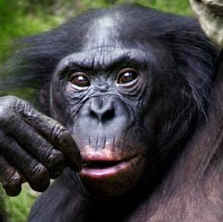

In [69]:
img=Image.open(fn); img

Need to subtract the VGG mean to make it work w/ VGG

In [72]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [73]:
np.array(img)

(222, 223, 3)

Also reshape to add the "batch_size"

In [74]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape

Here we get a pretrained net (VGG but with max pooling replaced with avg pooling to retain information)

In [ ]:
from vgg16_avg import VGG16_avg

In [ ]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)
plt.imshow(x[0]);

In [ ]:
def solve_image(eval_obj, img, niter):
    for _ in range(niter):
        img, min_val, info = fmin_l_bfgs_b(eval_obj.loss, img.flatten(),
                                        fprime=eval_obj.grads, maxfun=20)
        img = np.clip(img, -127, 127)
        print('Current loss value:', min_val)
    return img